In [47]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

In [155]:
L = 25
N = L*L     # particle number

rho = 1.0   # particle density
box_size = np.sqrt(N/rho)  # linear dimension of the box
temperature = 1.0

r_c = 100
r_c = r_c*r_c

In [157]:
@njit
def create_initial(N, box_side,temperature = 1.0):
    L = int(np.sqrt(N))
    
    x = np.zeros(N)
    y = np.zeros(N)
    
    v_x = np.zeros(N)
    v_y = np.zeros(N)
    
    count = 0
    for i in range(L):
        for j in range(L):
            
            # distribui as partículas numa rede quadrada centrada  
            x[count] = (i+0.5) - box_size/2
            y[count] = (j+0.5) - box_size/2
            
            # Escolhe a velocidade uniformemente num circulo unitario 
            phi = np.random.uniform(0,2*np.pi)
            v_x[count] = np.cos(phi)
            v_y[count] = np.sin(phi)
            count += 1
   
    # normaliza as posições para dentro da caixa  
    x = x/L*box_size
    y = y/L*box_size
    
    # normaliza as velocidades de acordo com o teorema da equiparticao da energia  
    prov=np.sqrt((2.0-2.0/N)*temperature)  

    v_x=v_x*prov  
    v_y=v_y*prov  

    # Zera o momento total das partículas  
    prov=np.sum(v_x)  
    v_x=v_x-prov/N  
    prov=np.sum(v_y)  
    v_y=v_y-prov/N  

   
    return x, y, v_x, v_y

In [146]:
@njit
def verlet_list(x,y,r_c, box_size):
    N = len(x)
    
    n_viz = np.zeros(N, dtype=np.int64)    # número de vizinhos por partícula
    viz = np.full(N*(N-1), -1, dtype=np.int64)      # os n_viz[i] vizinhos listados
    
    count = 0
    for i in range(N):             # loop sobre todas as partículas
        for j in range(N):         # loop sobre todos os possíveis vizinhos
            x_ij = x[i] - x[j]
            y_ij = y[i] - y[j]
            # corrige a distância entre partículas segundo a condição de contorno (condições de contorno periódicas)
            x_ij = x_ij - box_size*np.rint(x_ij/box_size)
            y_ij = y_ij - box_size*np.rint(y_ij/box_size)
            
            r2_ij = x_ij*x_ij + y_ij*y_ij   # quadrado da distância entre as partículas
    
            if r2_ij <= r_c and r2_ij != 0: 
                viz[count] = j
                count += 1
                n_viz[i] += 1
    
    viz_2 = np.empty(count, dtype=np.int64)
    for i in range(count):
        viz_2[i] = viz[i]
    
    return n_viz, viz_2

In [191]:
%time _ = verlet_list(x,y,r_c,box_size) 

Wall time: 4 ms


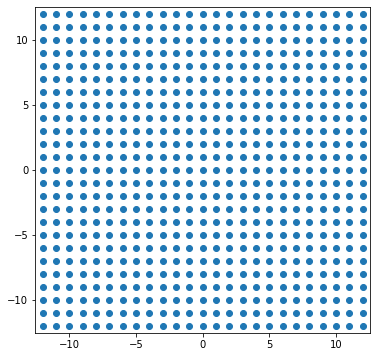

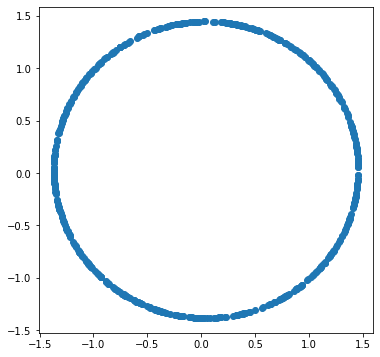

In [194]:
x,y,vx,vy = create_initial(N,box_size,temperature)
#n_viz, viz = vernet_list(x,y,1)
plt.figure(figsize=(6,6))
plt.xlim(-L/2 - 0.05,L/2 + 0.05)
plt.ylim(-L/2 - 0.05,L/2 + 0.05)
plt.scatter(x,y)
plt.show()
plt.figure(figsize=(6,6))
plt.scatter(vx,vy)
plt.show()
#print(n_viz)
#print(viz)

In [6]:
@njit
def simulate(x, y, v_x, v_y, r_c = 1.0):
    N = len(x)
    
    
    
    count = 0
    for i in range(N):
        for j in range(i+1,N):    
            r_xij = x[i] - x[j]
            r_yij = y[i] - y[j]
            r_ij = np.sqrt(r_xij*r_xij + r_yij*r_yij)
            # corrige a distância entre partículas segundo a condição de contorno (repetição da amostra)
            r_ij = r_ij - (L * round(int(r_ij/L)))
            if r_ij <= r_c:
                count += 1
                n_viz[i] += 1
                viz[count] = j 
    
    for i in range(N):
        for j in range(n_viz[i-1],n_viz[i]-1):
            r_xij = x[i] - x[j]
            r_yij = y[i] - y[j]
            r_ij = np.sqrt(r_xij*r_xij + r_yij*r_yij)
            # corrige a distância entre partículas segundo a condição de contorno (repetição da amostra)
            r_ij = r_ij - (L * round(int(r_ij/L)))